In [15]:
import tqdm
import random
import numpy as np
import pandas as pd
from collections import Counter
from itertools import cycle

from sklearn import datasets, metrics, tree
from sklearn.cluster import KMeans, MiniBatchKMeans, Birch, DBSCAN
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import graphviz
import tqdm

from sklearn import tree

In [16]:
titanic_train = pd.read_csv('/home/dramak/Pobrane/train.csv')
titanic_test = pd.read_csv('/home/dramak/Pobrane/test.csv')

X = titanic_train.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis = 1)
X = X.dropna()
X['Sex'] = pd.Categorical(X['Sex']).codes
X['Embarked'] = pd.Categorical(X['Embarked']).codes
print(X[X['Survived'] == 0].shape)
X.head()

(424, 8)


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,22.0,1,0,7.2500,2
1,1,1,0,38.0,1,0,71.2833,0
2,1,3,0,26.0,0,0,7.9250,2
3,1,1,0,35.0,1,0,53.1000,2
4,0,3,1,35.0,0,0,8.0500,2


In [17]:
def cross_validation(X, no=10, criterion='gini', max_depth=1000, min_samples_split=None, min_samples_leaf=None):
    err_sum = 0
    Y = X['Survived']
    X = X.drop('Survived', axis=1)
    indices = np.random.uniform(0, no, len(X)).astype(int)
    print('--------------------------------------')
    print(f'Cross validation using {criterion}')
    for i in range(no):
        x_train = X[indices != i]
        y_train = Y[indices != i]
        x_test = X[indices == i]
        y_test = Y[indices == i]
        
        if min_samples_split and min_samples_leaf:
            model = tree.DecisionTreeClassifier(criterion=criterion, max_depth=max_depth, 
                                        min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)
        else:
            model = tree.DecisionTreeClassifier(criterion=criterion, max_depth=max_depth)
            
        model.fit(x_train, y_train)
        predictions = model.predict(x_test)
        
        result = list(predictions == y_test)
        result_cnt = result.count(True) / len(result) * 100
          
        err_sum += 100-result_cnt
        print(f'Test: {i} -> score: {result_cnt}\n')
        
    print(f'Final error: {err_sum / no}\n')
        
        
def build_Tree(X_train, X_test, criterion='gini', max_depth=1000, min_samples_split=None, min_samples_leaf=None):
    Y_train = X_train['Survived']
    X_train = X_train.drop('Survived', axis=1)
    Y_test = X_test['Survived']
    X_test = X_test.drop('Survived', axis=1)

    model = None
    name = 'titanic.dot'
    #Reducing tree size
    if min_samples_split and min_samples_leaf:
        model = tree.DecisionTreeClassifier(criterion=criterion, max_depth=max_depth, 
                                        min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)
    else:
        model = tree.DecisionTreeClassifier(criterion=criterion, max_depth=max_depth)
        
    model.fit(X_train, Y_train)
    print(f'Classification using {criterion} on TEST')
    print(metrics.confusion_matrix(model.predict(X_test), Y_test))
    print(f'Score: {model.score(X_test, Y_test) * 100:.2f}%\n')
    print(f'\nClassification using {criterion} on TRAIN')
    print(metrics.confusion_matrix(model.predict(X_train), Y_train))
    print(f'Score: {model.score(X_train, Y_train) * 100:.2f}%\n\n')
    
    return model, X_train

def draw_tree(tree_,feature_names, target_names, name):
    dot_data = tree.export_graphviz(tree_, out_file=None) 
    graph = graphviz.Source(dot_data) 
    graph.render(name) 
    dot_data = tree.export_graphviz(tree_, out_file=None, 
                     feature_names=feature_names,  
                     class_names=target_names,  
                     filled=True, rounded=True,  
                     special_characters=True)  
    graph = graphviz.Source(dot_data)  
    return graph

In [18]:
X_train, X_test = train_test_split(X, test_size=0.3333)
gini_tree, gini_X = build_Tree(X_train, X_test, criterion='gini')
entropy_tree, entropy_X  = build_Tree(X_train, X_test, criterion='entropy')

cross_validation(X, criterion='entropy')
cross_validation(X, criterion='gini')

Classification using gini on TEST
[[120  35]
 [ 23  60]]
Score: 75.63%


Classification using gini on TRAIN
[[281   6]
 [  0 187]]
Score: 98.73%


Classification using entropy on TEST
[[120  31]
 [ 23  64]]
Score: 77.31%


Classification using entropy on TRAIN
[[281   6]
 [  0 187]]
Score: 98.73%


--------------------------------------
Cross validation using entropy
Test: 0 -> score: 79.16666666666666

Test: 1 -> score: 67.6056338028169

Test: 2 -> score: 80.95238095238095

Test: 3 -> score: 82.53968253968253

Test: 4 -> score: 75.32467532467533

Test: 5 -> score: 71.1864406779661

Test: 6 -> score: 76.74418604651163

Test: 7 -> score: 69.01408450704226

Test: 8 -> score: 77.94117647058823

Test: 9 -> score: 78.04878048780488

Final error: 24.14762925238645

--------------------------------------
Cross validation using gini
Test: 0 -> score: 79.6875

Test: 1 -> score: 77.77777777777779

Test: 2 -> score: 80.48780487804879

Test: 3 -> score: 68.75

Test: 4 -> score: 84.72222222222221



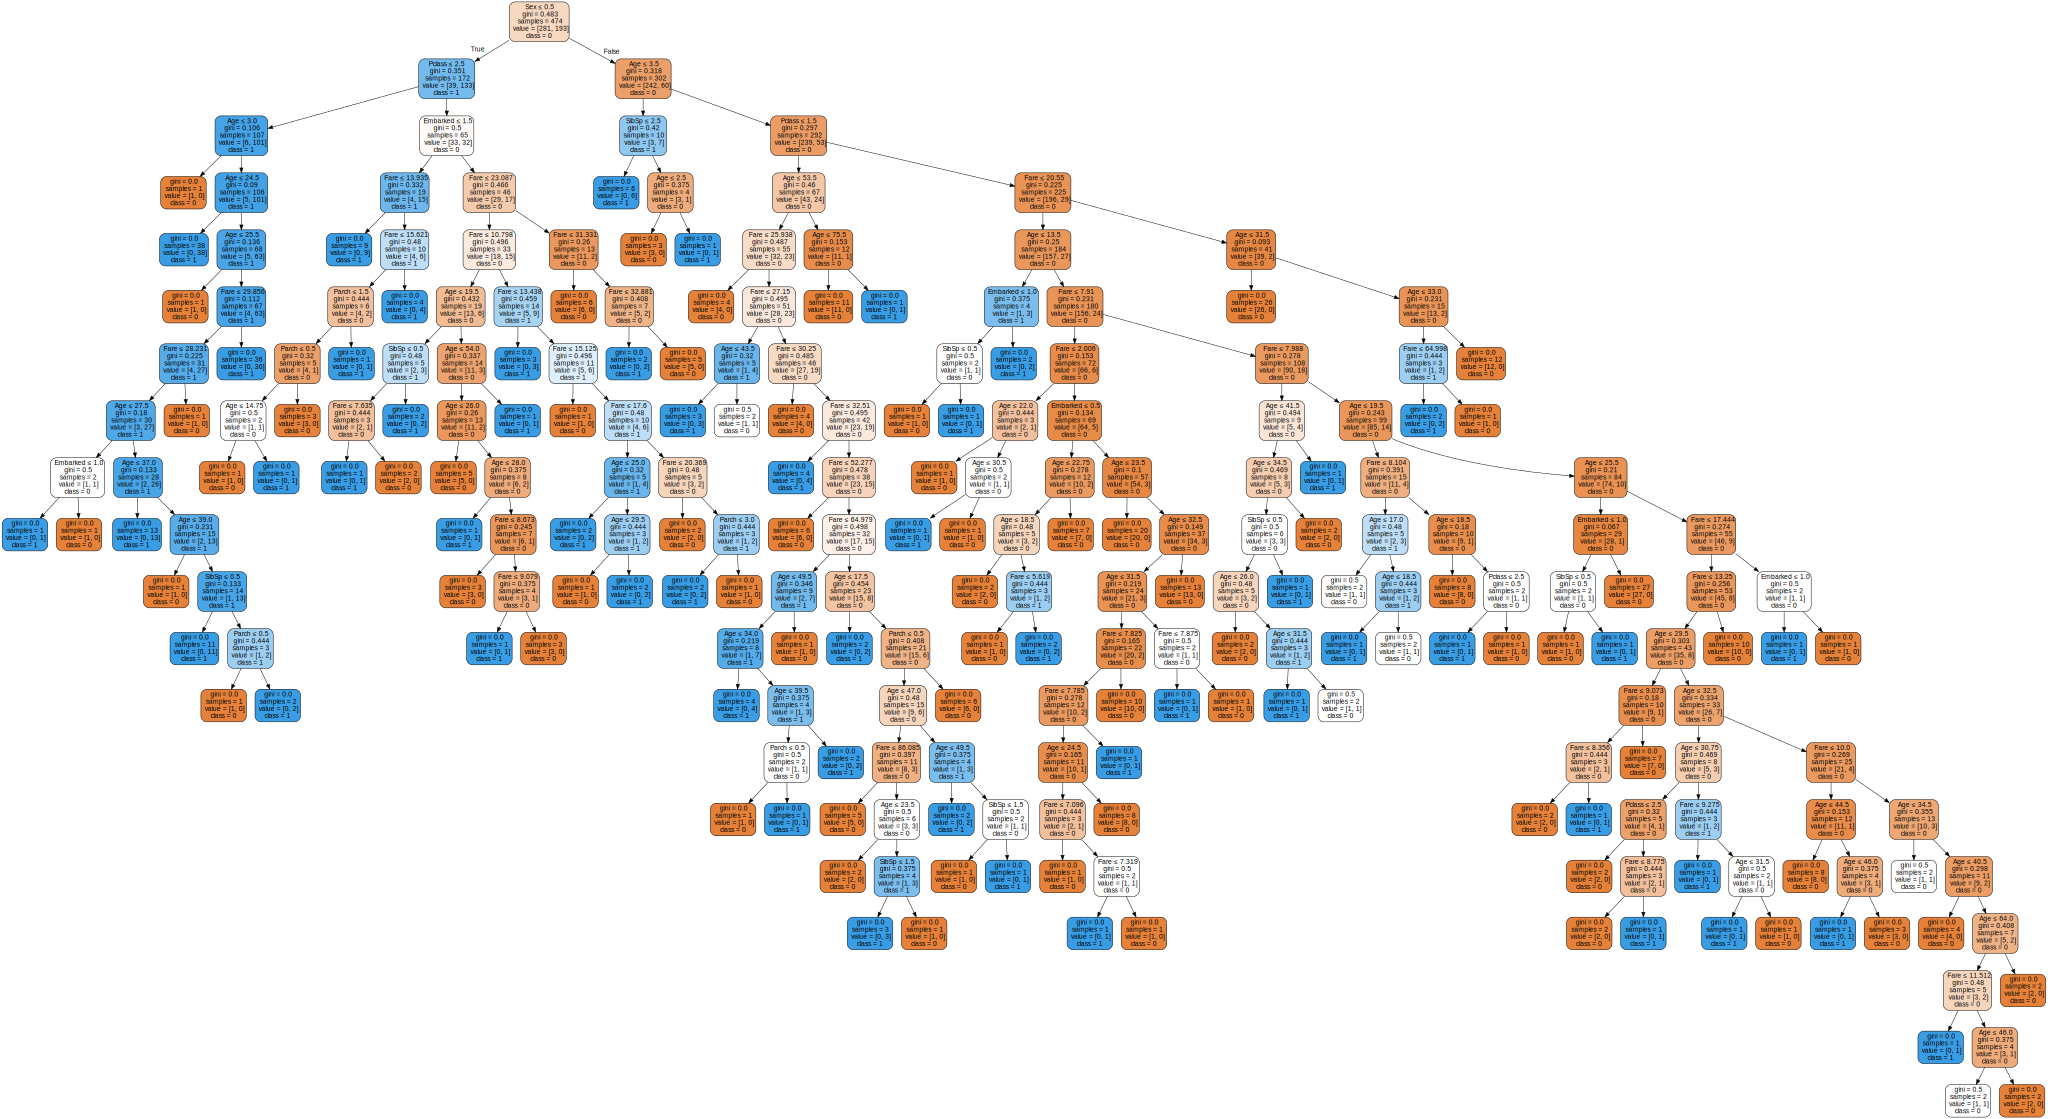

In [19]:
draw_tree(gini_tree, gini_X.columns, ['0','1'], 'titanic_gini')

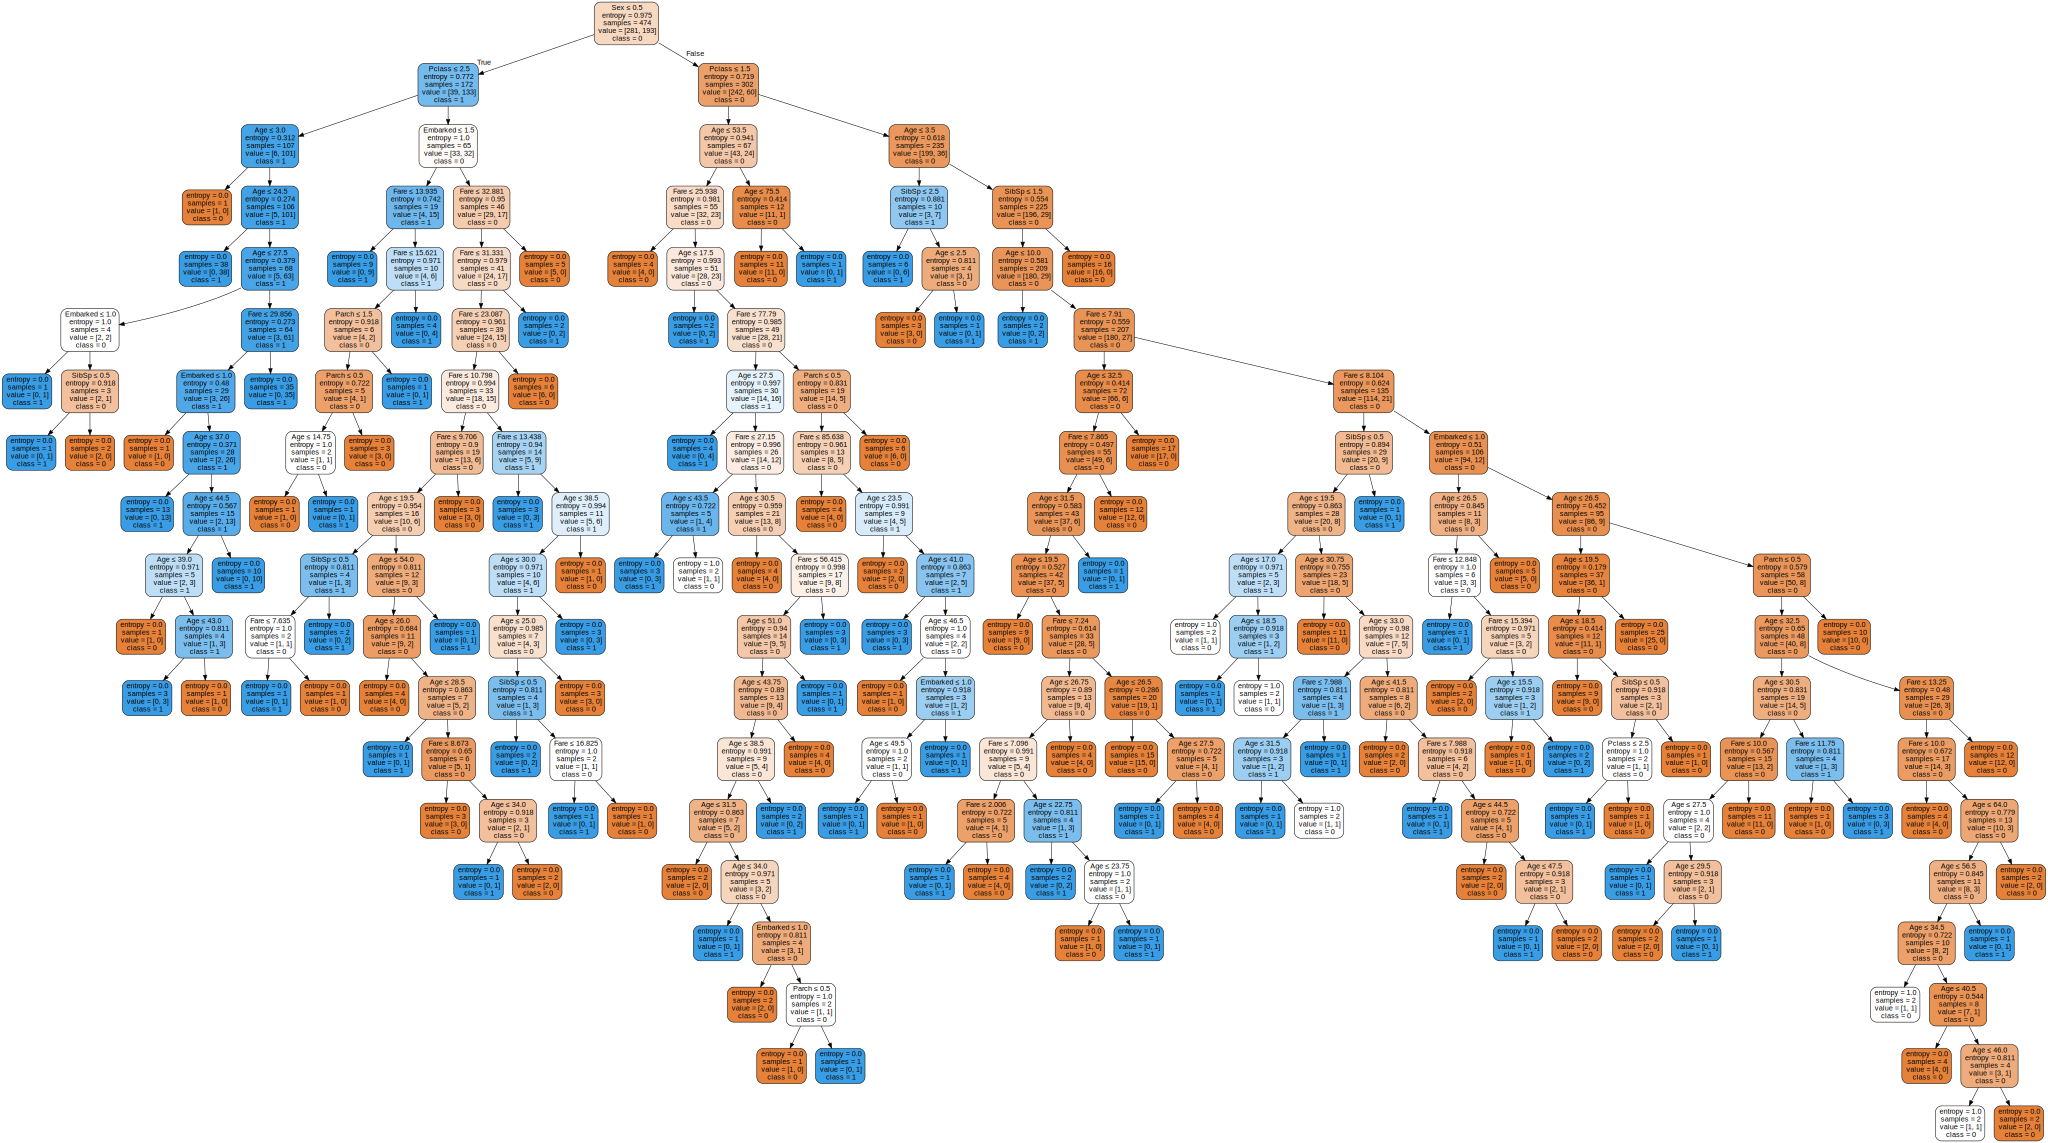

In [20]:
draw_tree(entropy_tree, entropy_X.columns, ['0','1'], 'titanic_entropy')

In [21]:
gini_tree, gini_X = build_Tree(X_train, X_test, criterion='gini', max_depth=5)
entropy_tree, entropy_X = build_Tree(X_train, X_test, criterion='entropy', max_depth=5)

cross_validation(X, criterion='entropy', max_depth=5)
cross_validation(X, criterion='gini', max_depth=5)

Classification using gini on TEST
[[131  38]
 [ 12  57]]
Score: 78.99%


Classification using gini on TRAIN
[[271  59]
 [ 10 134]]
Score: 85.44%


Classification using entropy on TEST
[[137  42]
 [  6  53]]
Score: 79.83%


Classification using entropy on TRAIN
[[278  67]
 [  3 126]]
Score: 85.23%


--------------------------------------
Cross validation using entropy
Test: 0 -> score: 90.38461538461539

Test: 1 -> score: 82.6086956521739

Test: 2 -> score: 80.0

Test: 3 -> score: 76.5432098765432

Test: 4 -> score: 70.23809523809523

Test: 5 -> score: 73.33333333333333

Test: 6 -> score: 79.41176470588235

Test: 7 -> score: 84.28571428571429

Test: 8 -> score: 78.37837837837837

Test: 9 -> score: 84.05797101449275

Final error: 20.075822213077117

--------------------------------------
Cross validation using gini
Test: 0 -> score: 83.75

Test: 1 -> score: 81.25

Test: 2 -> score: 76.5625

Test: 3 -> score: 83.78378378378379

Test: 4 -> score: 83.09859154929578

Test: 5 -> score: 85.507

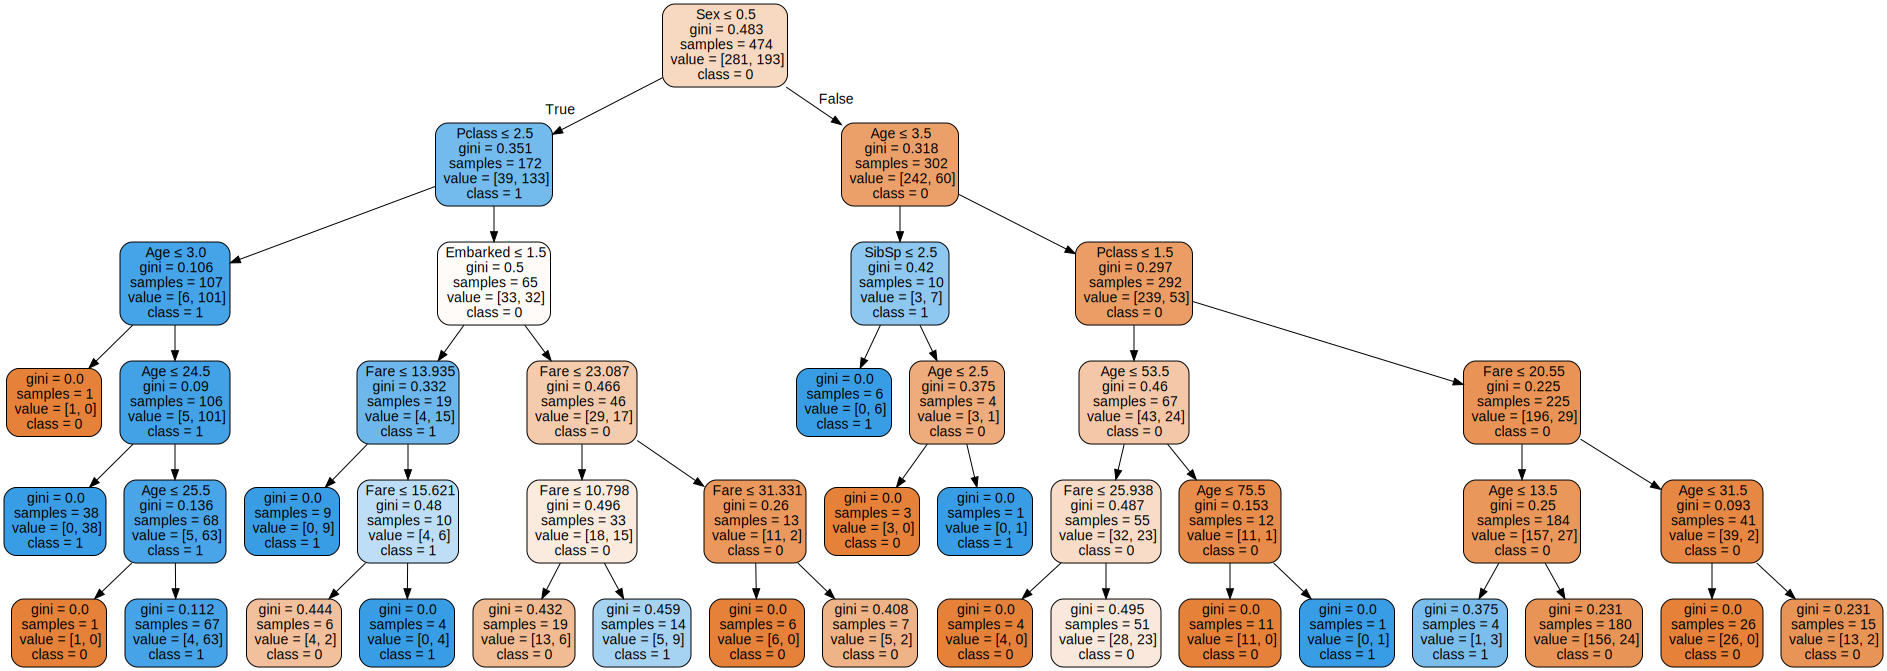

In [22]:
draw_tree(gini_tree, gini_X.columns, ['0','1'], 'titanic_gini_depth')

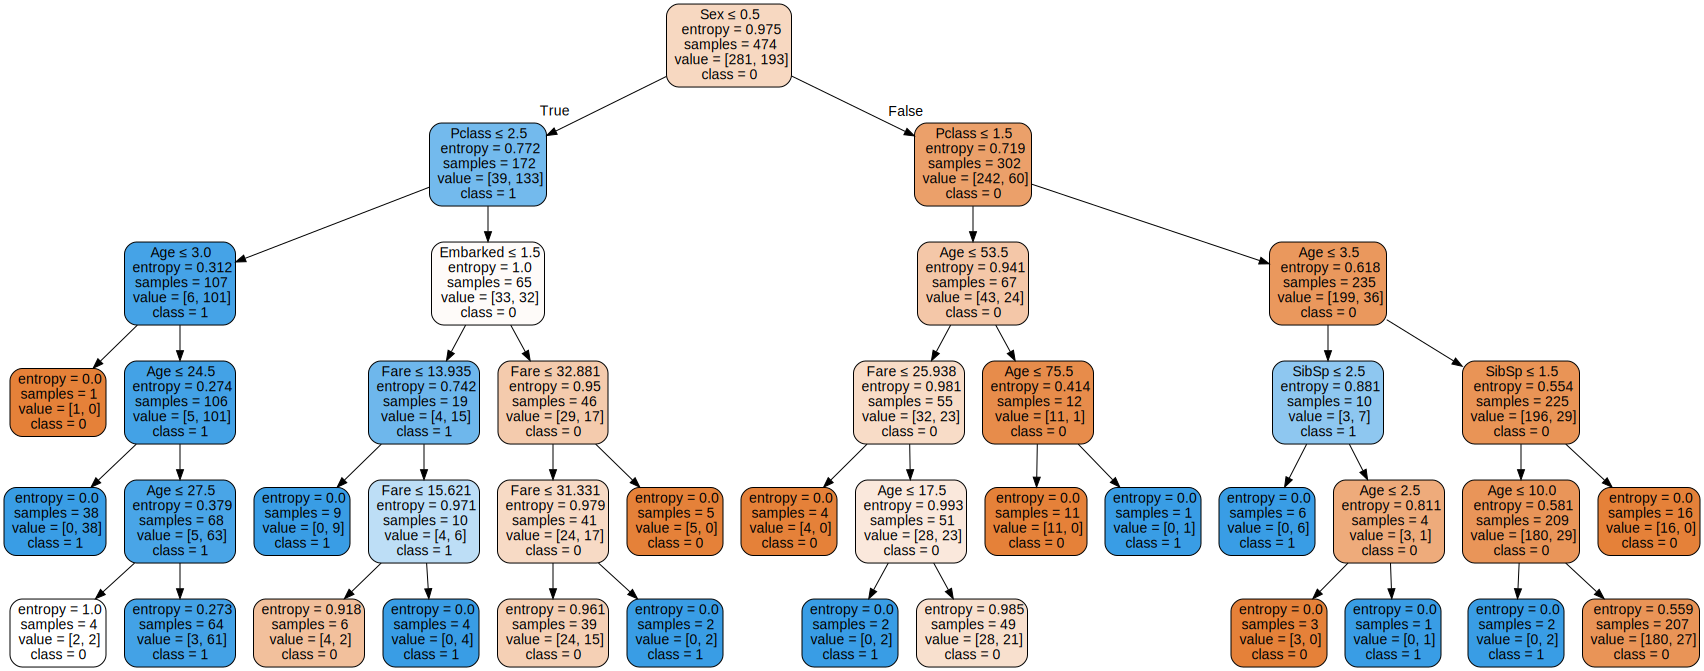

In [23]:
draw_tree(entropy_tree, entropy_X.columns, ['0','1'], 'titanic_entropy_depth')

In [24]:
gini_tree, gini_X = build_Tree(X_train, X_test, criterion='gini', max_depth=5, min_samples_split=10, min_samples_leaf=10)
entropy_tree, entropy_X = build_Tree(X_train, X_test, criterion='entropy', max_depth=5, min_samples_split=10, min_samples_leaf=10)

cross_validation(X, criterion='entropy', max_depth=5, min_samples_split=10, min_samples_leaf=5)
cross_validation(X, criterion='gini', max_depth=5, min_samples_split=10, min_samples_leaf=5)

Classification using gini on TEST
[[127  36]
 [ 16  59]]
Score: 78.15%


Classification using gini on TRAIN
[[263  61]
 [ 18 132]]
Score: 83.33%


Classification using entropy on TEST
[[125  34]
 [ 18  61]]
Score: 78.15%


Classification using entropy on TRAIN
[[260  54]
 [ 21 139]]
Score: 84.18%


--------------------------------------
Cross validation using entropy
Test: 0 -> score: 80.28169014084507

Test: 1 -> score: 86.11111111111111

Test: 2 -> score: 76.81159420289855

Test: 3 -> score: 79.6875

Test: 4 -> score: 79.1044776119403

Test: 5 -> score: 75.40983606557377

Test: 6 -> score: 82.43243243243244

Test: 7 -> score: 80.95238095238095

Test: 8 -> score: 78.37837837837837

Test: 9 -> score: 77.63157894736842

Final error: 20.3199020157071

--------------------------------------
Cross validation using gini
Test: 0 -> score: 80.35714285714286

Test: 1 -> score: 73.01587301587301

Test: 2 -> score: 75.30864197530865

Test: 3 -> score: 75.34246575342466

Test: 4 -> score: 80.2631

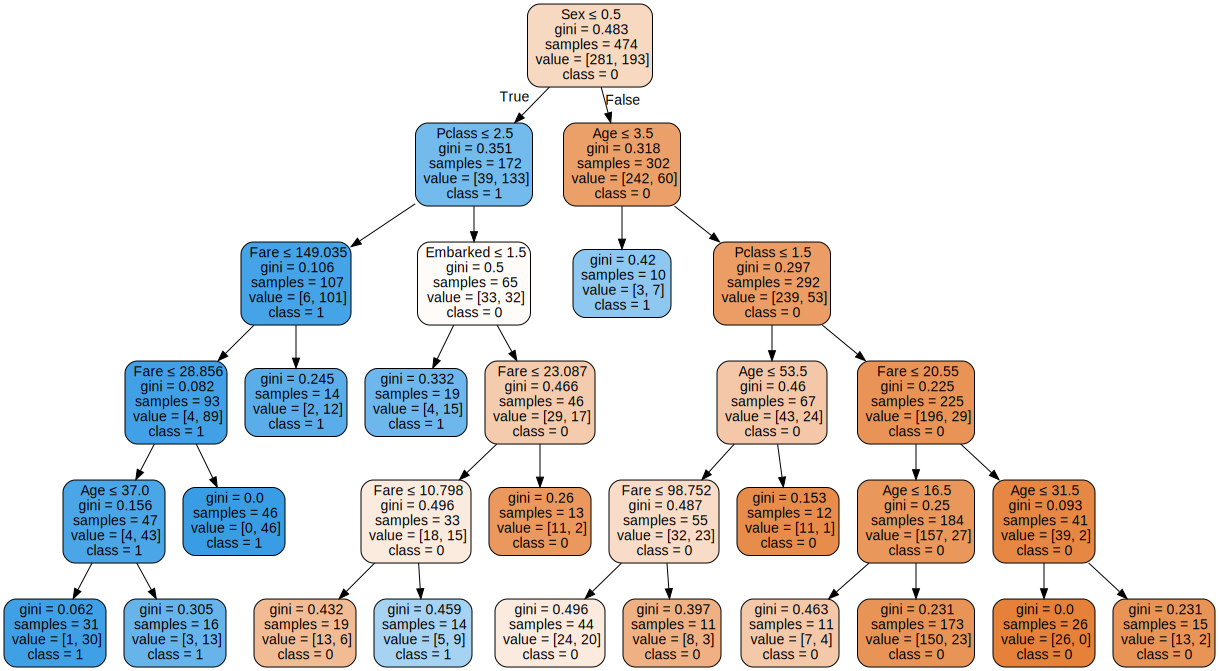

In [25]:
draw_tree(gini_tree, gini_X.columns, ['0','1'], 'titanic_gini_prunned')

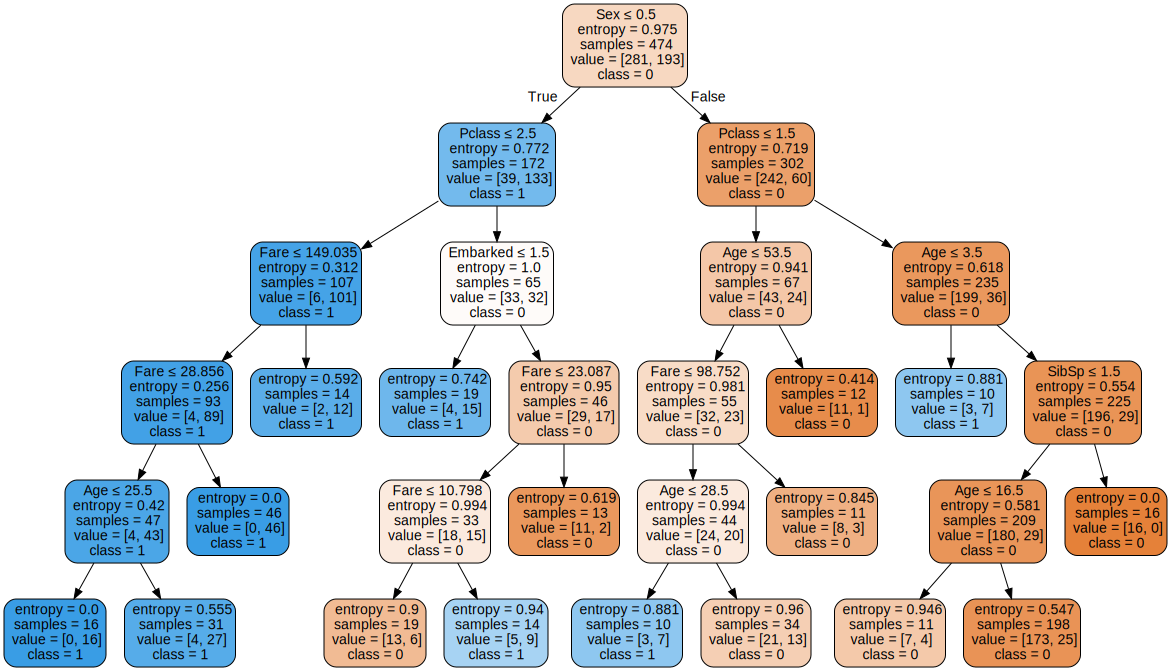

In [26]:
draw_tree(entropy_tree, entropy_X.columns, ['0','1'], 'titanic_entropy_prunned')